<a href="https://colab.research.google.com/github/yucellgereklioglu/datasciencework/blob/main/Student_Habits_vs_Academic_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [159]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import r2_score,root_mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('/content/student_habits_performance.csv')
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


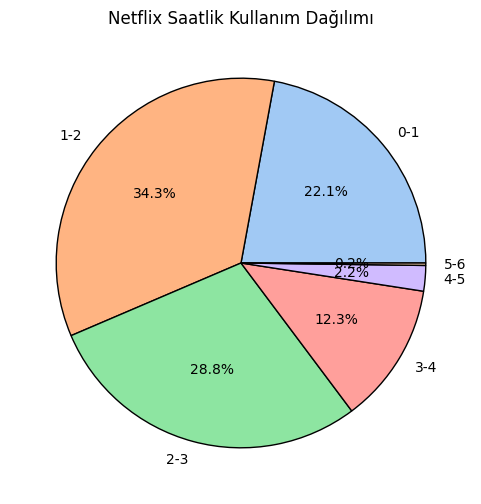

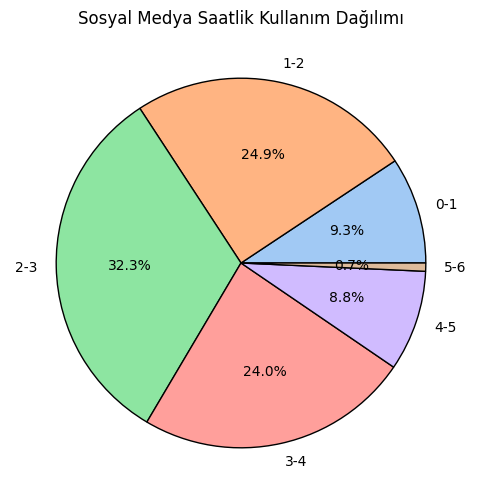

In [3]:
df['netflix_range'] = pd.cut(df['netflix_hours'], bins=[0, 1, 2, 3, 4, 5, 6], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6'])
plt.figure(figsize=(6, 6))
df['netflix_range'].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Netflix Saatlik Kullanım Dağılımı")
plt.ylabel('')
plt.show()
df['social_range'] = pd.cut(df['social_media_hours'], bins=[0, 1, 2, 3, 4, 5, 6], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6'])

plt.figure(figsize=(6, 6))
df['social_range'].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Sosyal Medya Saatlik Kullanım Dağılımı")
plt.ylabel('')
plt.show()


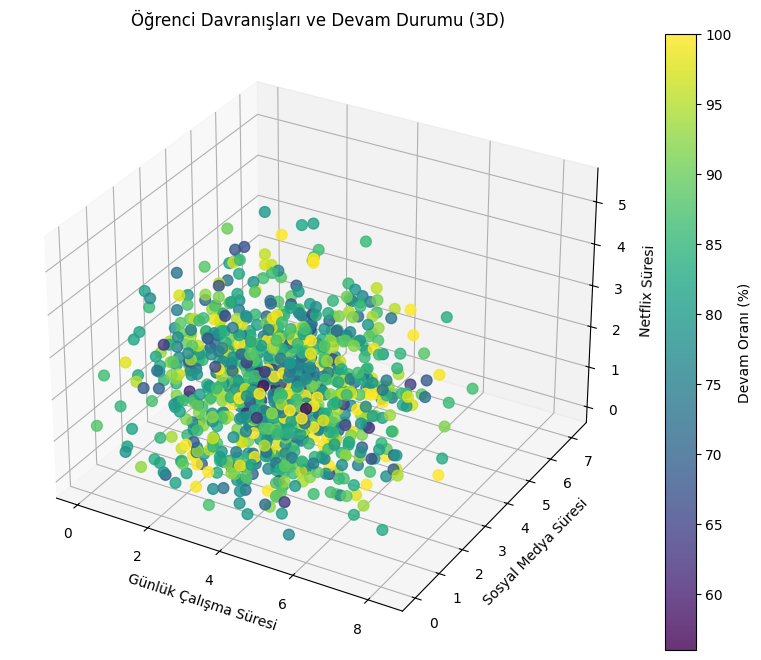

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df['study_hours_per_day'],
    df['social_media_hours'],
    df['netflix_hours'],
    c=df['attendance_percentage'],
    cmap='viridis',
    s=60,
    alpha=0.8
)
ax.set_xlabel('Günlük Çalışma Süresi')
ax.set_ylabel('Sosyal Medya Süresi')
ax.set_zlabel('Netflix Süresi')
ax.set_title('Öğrenci Davranışları ve Devam Durumu (3D)')
cbar = plt.colorbar(scatter)
cbar.set_label('Devam Oranı (%)')
plt.show()


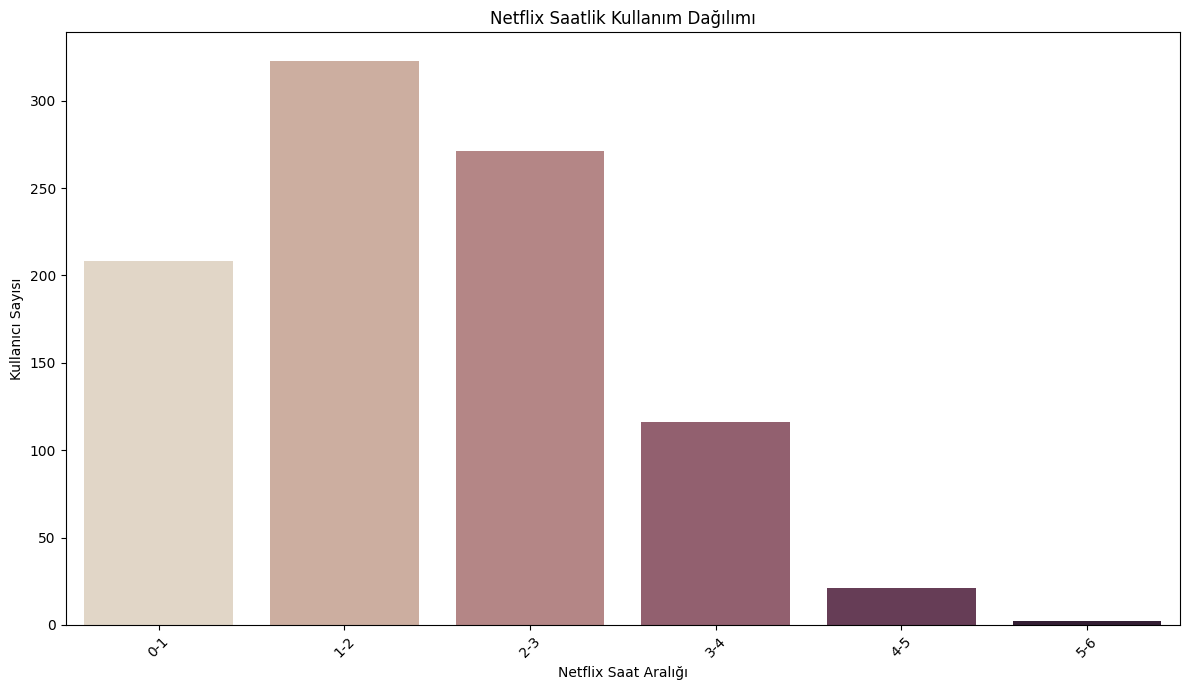

In [5]:
plt.figure(figsize=(12, 7))
sns.countplot(
    x="netflix_range",
    data=df,
    palette="ch:.25"
)
plt.title("Netflix Saatlik Kullanım Dağılımı")
plt.xlabel("Netflix Saat Aralığı")
plt.ylabel("Kullanıcı Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


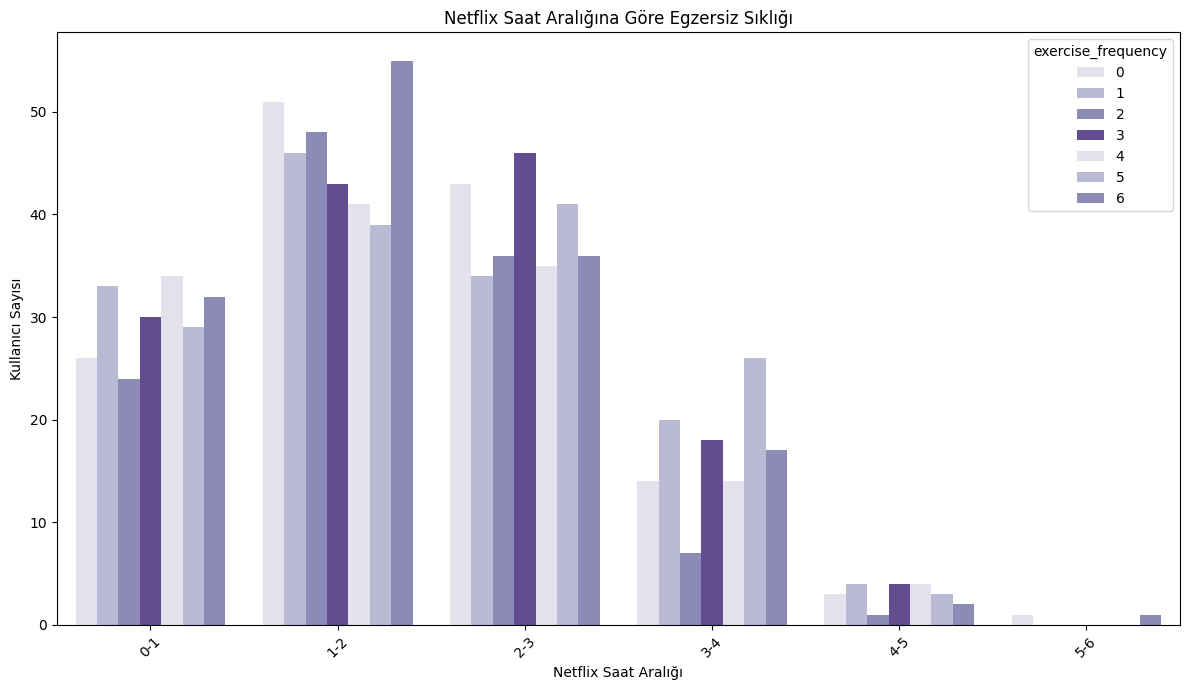

In [6]:
plt.figure(figsize=(12, 7))
sns.countplot(
    x="netflix_range",
    hue="exercise_frequency",
    data=df,
    palette=sns.color_palette("Purples", n_colors=4)
)

plt.title("Netflix Saat Aralığına Göre Egzersiz Sıklığı")
plt.xlabel("Netflix Saat Aralığı")
plt.ylabel("Kullanıcı Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
le=LabelEncoder()
df['gender']=le.fit_transform(df['gender'])
df['part_time_job']=le.fit_transform(df['part_time_job'])
df['diet_quality']=le.fit_transform(df['diet_quality'])
df['parental_education_level']=le.fit_transform(df['parental_education_level'])
df['internet_quality']=le.fit_transform(df['internet_quality'])
df['extracurricular_participation']=le.fit_transform(df['extracurricular_participation'])


In [72]:
y = df['exam_score']
X = df.drop(['exam_score', 'netflix_range', 'social_range','student_id'], axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

In [73]:
X_test

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation
841,24,1,3.3,1.5,1.8,1,81.4,6.9,0,5,1,0,6,0
956,20,0,3.2,2.3,1.5,0,71.0,5.0,1,6,1,1,3,0
544,17,0,4.1,2.8,1.6,0,100.0,7.3,2,6,0,0,7,0
173,20,0,5.7,2.1,2.4,0,85.8,5.6,0,3,2,1,4,1
759,23,0,2.8,4.1,1.7,1,90.2,5.2,0,1,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,17,0,3.2,2.8,4.3,0,86.1,7.7,0,4,1,0,4,1
192,17,0,4.3,3.3,2.3,0,86.5,5.5,2,4,2,1,6,0
398,24,1,5.7,2.9,1.7,0,77.3,6.4,1,0,2,1,2,1
450,22,0,3.1,3.3,1.8,0,98.5,6.5,0,2,0,0,8,0


In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
X_train = X_train.drop(['student_id'], axis=1)
X_test=X_test.drop(['student_id'],axis=1)

In [117]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2
)
xgb = XGBRegressor(
    n_estimators=1400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    enable_categorical=True
)

cat = CatBoostRegressor(
    iterations=200,
    learning_rate=0.04,
    depth=6,
    verbose=0
)
stack = StackingRegressor(estimators=[('xgb', xgb),('rf', rf),('cat', cat)],
final_estimator=LinearRegression(),
cv=5,
n_jobs=-1
)


In [119]:
stack.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_cons...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1400, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('rf',
                               RandomForestRegressor(max_depth=7,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=300)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7fd95cd76e50>)],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [134]:
X_meta=np.zeros((X_test.shape[0],3))
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    rf.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)
    cat.fit(X_tr, y_tr)
X_meta = np.zeros((X_train.shape[0], 3))
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    rf.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)
    cat.fit(X_tr, y_tr)
    X_meta[val_idx, 0] = rf.predict(X_val)
    X_meta[val_idx, 1] = xgb.predict(X_val)
    X_meta[val_idx, 2] = cat.predict(X_val)
meta_model = Ridge()
meta_model.fit(X_meta, y_train)
y_predmeta=meta_model.predict(X_meta)
print("Meta Model R2 Score:", r2_score(y_train, y_predmeta))
print("Meta Model RMSE:", root_mean_squared_error(y_train, y_predmeta))


Meta Model R2 Score: 0.890906827096273
Meta Model RMSE: 5.597825337105378


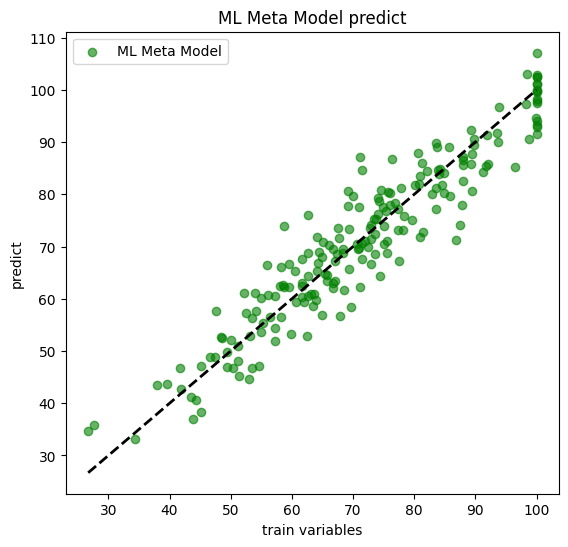

In [153]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_meta, alpha=0.6, color='green', label='ML Meta Model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("train variables")
plt.ylabel("predict")
plt.title("ML Meta Model predict")
plt.legend()

In [150]:
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
cat.fit(X_train, y_train)
X_meta = np.column_stack([
rf.predict(X_train),
xgb.predict(X_train),
cat.predict(X_train)])
X_meta_train = np.column_stack([
    rf.predict(X_train),
    xgb.predict(X_train),
    cat.predict(X_train)
    ])
X_meta_test = np.column_stack([
    rf.predict(X_test),
    xgb.predict(X_test),
    cat.predict(X_test)
])

In [160]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_meta_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_meta_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)
X_meta_test = np.column_stack([
    rf.predict(X_test),
    xgb.predict(X_test),
    cat.predict(X_test)
])
y_pred_nn = model.predict(X_meta_test).flatten()

from sklearn.metrics import r2_score, mean_squared_error
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)
print("Neural Network:")
print(f"RMSE: {rmse_nn}")
print(f"R2 Score: {r2_nn}")


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4862.0352 - mae: 67.7273 - val_loss: 4205.0225 - val_mae: 63.1359
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4743.5771 - mae: 66.9359 - val_loss: 3647.0991 - val_mae: 59.3256
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4404.5527 - mae: 64.9246 - val_loss: 2961.1746 - val_mae: 53.7880
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3645.0481 - mae: 58.9438 - val_loss: 2370.3638 - val_mae: 47.9719
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2870.5405 - mae: 52.3898 - val_loss: 1529.5076 - val_mae: 37.3901
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1905.0844 - mae: 41.9458 - val_loss: 792.2963 - val_mae: 25.0398
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1146.9797 - mae: 30.9658 - val_loss: 288.2939 - val_mae: 14.0432
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 676.2418 - mae: 22.3145 - val_loss: 158.9328 - val_mae: 10.8040
Epoc

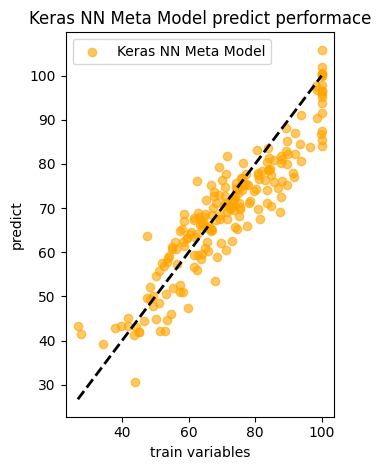

In [161]:
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_nn, alpha=0.6, color='orange', label='Keras NN Meta Model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("train variables")
plt.ylabel("predict")
plt.title("Keras NN Meta Model predict performace")
plt.legend()
plt.tight_layout()
plt.show()

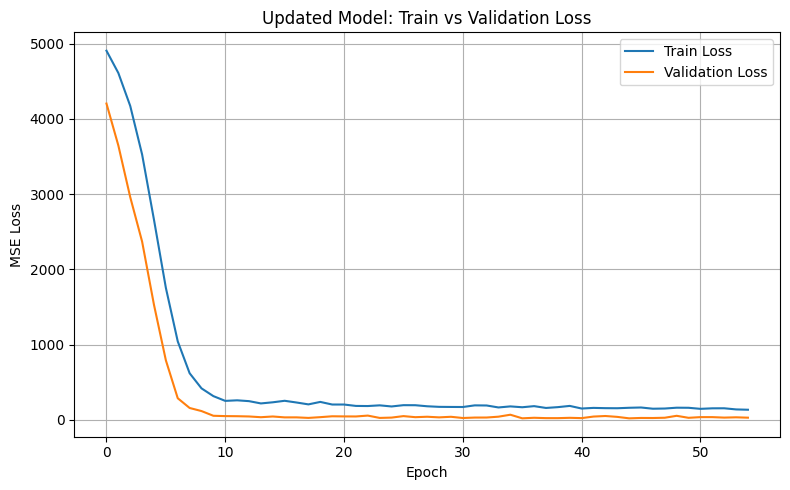

In [162]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Updated Model: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


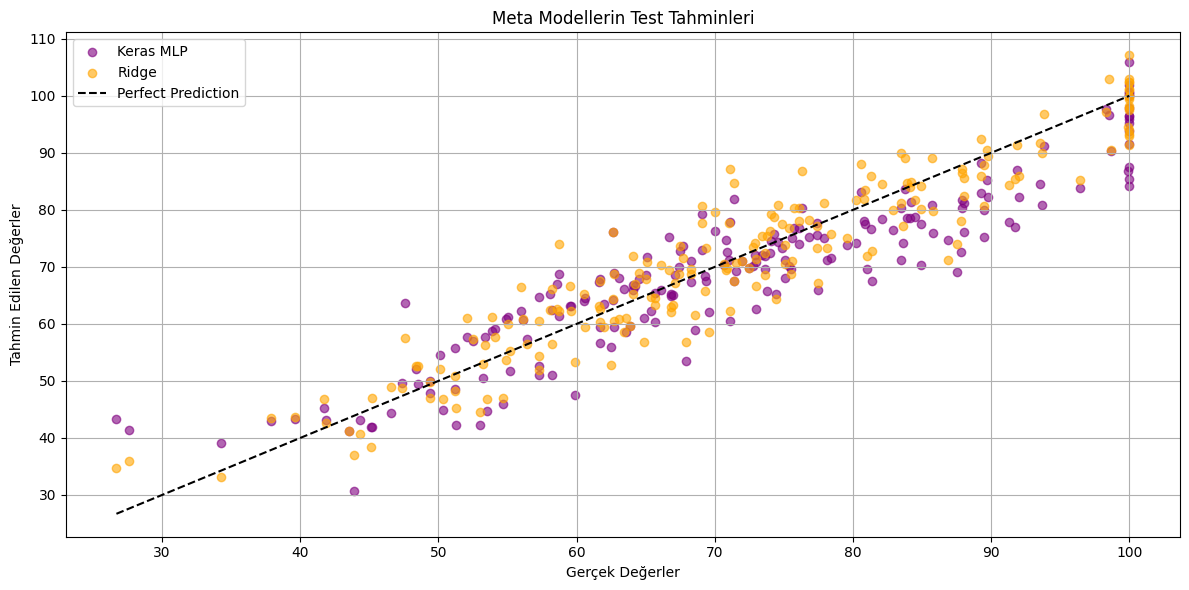

In [165]:
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred_nn, color='purple', label='Keras MLP', alpha=0.6)
plt.scatter(y_test, y_pred_meta, color='orange', label='Ridge', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Perfect Prediction')
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Meta Modellerin Test Tahminleri")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
